In [1]:
# scipy.io.savemat('data/1/data.mat',dict([('ks_data_origin',ks_data_origin),
#                 ('b.output_w',b.output_w),('rmse',rmse),('rmse_vec',rmse_vec),
#                 ('rmse_vert',rmse_vert),('pred_output',pred_output),('xx_',xx_),
#                 ('tt',tt)]))

In [1]:
#!/usr/bin/python

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import scipy.io

# import os
# import sys
import numpy as np

import time

from reservoir import Reservoir
import data1D
import data_utils

%load_ext autoreload
%autoreload 2
%aimport data1D
%aimport reservoir


%matplotlib inline
import matplotlib.pyplot as plt

# setx PATH "%PATH%;C:\Octave\Octave-5.1.0.0

In [2]:
# Input data
n_sequence=1
spatial_points = 30
lyap_exp = 0.0461
n_train = 5000
n_test = 4000
forget = 500
parallel_runs = 1
ks_data_origin, xx, tt = data1D.kuramoto_sivashinsky_from_dataset(
    sequence_length=n_train+n_test, n_sequence=n_sequence, spatial_points=spatial_points)
# ks_data_origin=ks_data_origin+np.random.rand(ks_data_origin.shape[0],ks_data_origin.shape[1],ks_data_origin.shape[2])
ks_data_train = ks_data_origin[:, :n_train, :]
input_shape=ks_data_train.shape

In [3]:
# b.activation_param0 = None
b = Reservoir(n_res=5000, res_scale=0.54, res_encoding='phase',
#               remove_saturated_neurons=True, n_saturated_neurons=20, # reservoir cleanup 
              input_enc_param=np.pi, res_enc_param=np.pi,
              input_scale=0.66, input_encoding='phase',
              scale_input_MinMax = (0, 1), scale_output_MinMax = (0, 1), # data standardization
              raw_input_feature = True, enc_input_feature = False, # concatenated states properties
              random_projection='simulation', weights_type='complex gaussian',
              activation_fun='intensity_in_tanh', activation_param=None,
              parallel_runs=parallel_runs, bias_scale=0, leak_rate=0,
              pred_horizon=1, rec_pred_steps=500, forget = forget,
              train_method='ridge', train_param=0.25, verbose=1
             )

In [16]:
b.leak_rate = 0

In [17]:
# Algorithm training
b.fit(ks_data_train);

Reservoir Computing algorithm - Training phase:

Initialization complete. 		Elapsed time: 2.2265396118164062 s



Reservoir iterations complete. 		Elapsed time: 72.72154760360718 s
Training complete. 			Elapsed time: 0.3106369972229004 s
Training score: 0.9999286438372239


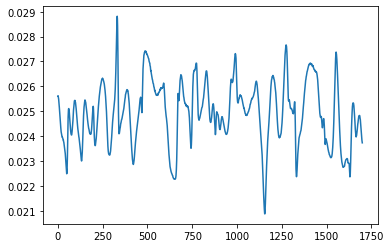

In [18]:
plt.plot(np.std(b.c[:, :-65].T, axis=0))

In [19]:
print(b.activation_param)
print(b.activation_param0)

6.42644718326457
2.3748650533715576


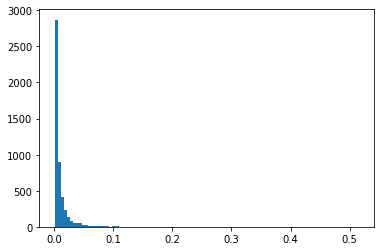

In [20]:
plt.hist((b.yy).T, bins=100);

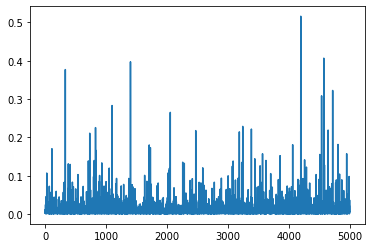

In [21]:
plt.plot(b.yy.T)

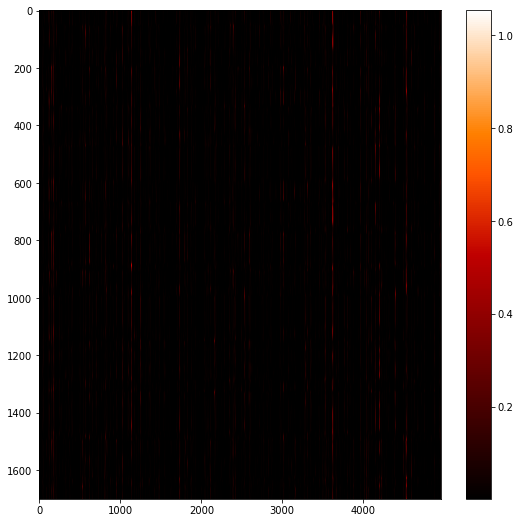

In [22]:
plt.figure(1,figsize=(9,9))
im=plt.imshow(b.c[:,:-65], cmap='gist_heat', interpolation='none', aspect = 1.2*b.c.shape[1]/b.c.shape[0])
plt.colorbar(im)

In [23]:
# testing data
# ks_data_test = data_utils.scale(ks_data_origin[:, n_train:, :], [0, 1])
ks_data_test = ks_data_origin[:, n_train:, :]

# Algorithm testing
b.parallel_test_runs=200
pred_output, rmse, rmse_vec, rmse_vert = b.predict_and_score(ks_data_test, detailed_score=True)

Reservoir Computing algorithm - Testing phase:

Initialization complete. 		Elapsed time: 0.008950948715209961 s



Reservoir iterations complete. 		Elapsed time: 340.28592562675476 s
Testing complete. 			Elapsed time: 5.439924240112305 s
Testing score: 0.3565722841122231


best plot is at 144


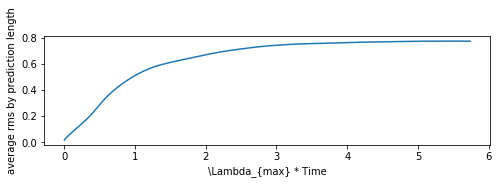

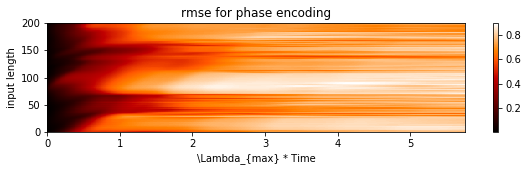

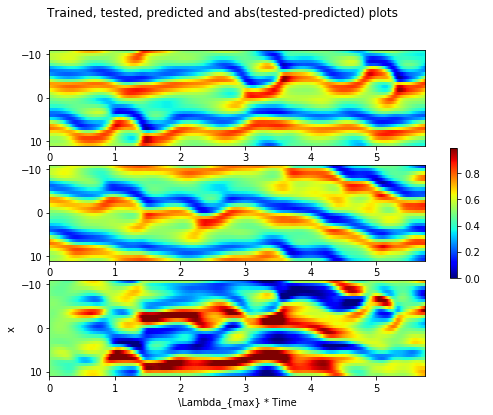

In [24]:
total_pred = (rmse.shape[1])
length_input = pred_output.shape[0] - total_pred
time_input = range(rmse.shape[0])
time_pred = tt[0:total_pred]*lyap_exp
t_min = 0
t_max = (tt[b.forget+total_pred]-tt[b.forget])*lyap_exp
x_min = xx.min()
x_max = xx.max()

plt.figure(1,figsize=(8,2))
plt.ylabel('average rms by prediction length')
plt.xlabel('\Lambda_{max} * Time')
plt.plot(time_pred[:], rmse_vec[:])
# scipy.io.savemat('time_pred_new_2.mat', dict(time_pred_new_2=time_pred))
# scipy.io.savemat('rmse_vec_new_2.mat', dict(rmse_vec_new_2=rmse_vec))
plt.show;
# plt.savefig('phase_LM_kuramoto_rmse.png', dpi=400)

plt.figure(2,figsize=(10,2))
plt.title('rmse for phase encoding')
plt.ylabel('input length')
plt.xlabel('\Lambda_{max} * Time')
im=plt.imshow(rmse[:,:], cmap='gist_heat', interpolation='nearest', 
              aspect = 0.003*total_pred/b.parallel_test_runs, 
              extent = [t_min , t_max, 0, b.parallel_test_runs])
plt.colorbar(im)
plt.show;

############################################################################
n_input = np.argmin(np.sum(rmse[:,:], axis=1)) # np.argmin(rmse_vert)
# n_input = 198
#############################################################################
total_pred = b.pred_horizon*b.rec_pred_steps

input_data = data_utils.data_preprocessing(
    ks_data_test, standardize=b.output_standardize,
    scale_min_max=b.scale_output_MinMax)[0, b.forget:b.forget+total_pred, :]
targetted_data = data_utils.data_preprocessing(
    ks_data_test, standardize=b.output_standardize,
    scale_min_max=b.scale_output_MinMax)[0, n_input+b.forget:n_input+b.forget+total_pred, :]

prediction = pred_output[n_input, :].reshape(targetted_data.shape)

vmax = max(np.concatenate((targetted_data, input_data)).flatten())
vmin = 0

# plot training data
fig, axs = plt.subplots(3, 1, sharex=False, figsize=(9,6))
plt.suptitle('Trained, tested, predicted and abs(tested-predicted) plots                       ')
plt.ylabel('x')
plt.xlabel('\Lambda_{max} * Time')

datum = [targetted_data, prediction, targetted_data-prediction+0.5]
for i in range(3):
        im=axs[i].imshow(datum[i].T, cmap=plt.get_cmap('jet'), interpolation='nearest', 
                         aspect = 0.004*total_pred/spatial_points, 
                         extent = [t_min , t_max, x_min , x_max], vmin=vmin, vmax=vmax)
        axs[i].invert_yaxis()
#     im=axs[i].pcolormesh(time_axs, xx_axs, datum[i].T, cmap=plt.get_cmap('jet'), vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.4)
# plt.savefig('phase_SLM_kuramoto_pred.png', dpi=400)

print('best plot is at '+str(np.argmin(rmse_vert)))

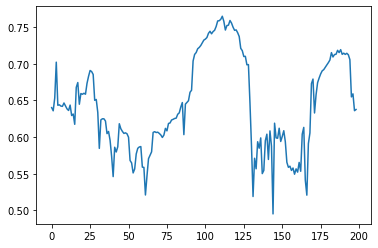

In [25]:
plt.plot(rmse_vert[:])